## Multi-scale Residual Dense Network

---



## The below network I am going to implement.

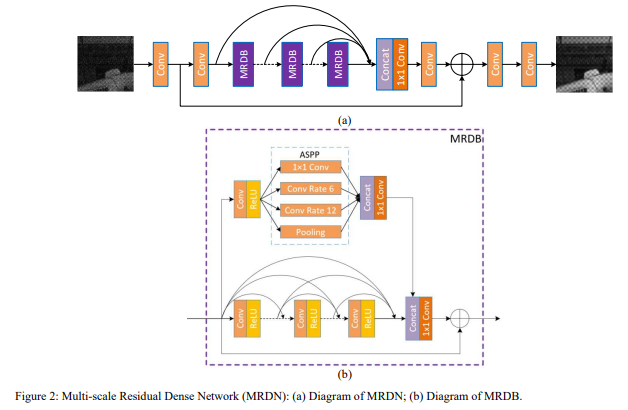

In [ ]:
load_img('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/MRDN.PNG')

Related papers<br>
https://arxiv.org/pdf/2005.04117.pdf    this paper presents more than 10 architectures used for real world image denoising as part of competion in 2020. I am using architecture which won the second rank .<br> 

Research paper  I am using the architecture from can be found in the below link<br>
https://openaccess.thecvf.com/content_CVPRW_2020/papers/w31/Bao_Real_Image_Denoising_Based_on_Multi-Scale_Residual_Dense_Block_and_CVPRW_2020_paper.pdf


#### Explanation<br>
Real Image Denoising based on Multi-scale Residual Dense Block.  MRDN architecture is proposed by the Samsung SLSI MSL team in the competion 'NTIRE 2020 Challenge on Real Image Denoising'.<br>

The Multi-scale Residual Dense Network (MRDN) is 
based on a new basic module, the Multi-scale Residual 
Dense Block (MRDB), as shown in Fig. 2 (a). MRDB 
combines multi-scale features from the ASPP and other 
features from the traditional residual dense block (RDB). 
As shown in Fig. 2 (b), the ASPP  contains four 
parallel network blocks including conv 1×1, conv Rate 6, 
conv Rate 12 and pooling. The conv Rate 6 and conv Rate 
12 denote the 3×3 dilated convolutions with the dilation rate 
of 6 and 12, respectively. Conv Rate 6, conv Rate 12 and 
image pooling can well capture the multi-scale features of 
the block input. The features outputted from the ASPP are 
concatenated and compressed to be combined with other 
features from the RDB. To have a seamless local residual 
connection, this concatenated feature is compressed with 
another conv 1×1 before an element-wise adder. 
The output of the MRDB preserves the same number of 
channels of its input to avoid the exponential complexity 
increase. With the MRDB as a building module, the MRDN 
constructs the network using the similar way as the residual 
dense network (RDN) by cascading the MRDBs with 
dense connections. Specifically, the outputs of the MRDBs 
are concatenated and compressed with a conv 1×1, and a 
global residual connection is adopted to obtain clean 
features. 



In [1]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input,Conv2D
from keras import backend as K
import numpy as np
from keras.layers import BatchNormalization,Activation,Subtract,Add,concatenate
from keras.layers import Conv2D, MaxPooling2D,Dropout
from keras.optimizers import Adam
import keras
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from tensorflow.image import psnr
from tensorflow.image import ssim 
from keras.callbacks import  LearningRateScheduler,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import glob
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os
from tqdm.notebook import tqdm
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from skimage.util import img_as_ubyte




In [2]:
#mounting the google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data')

In [3]:
#current directory
os.chdir('/content')
root_path='/content'
#root_path='/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset'
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset')

In [5]:
#This function used to download from my google drive to colab disk
#https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory
#!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_clean/' '/content/resized_train_clean'
#!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_noisy/' '/content/resized_train_noisy'
#!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_clean/' '/content/resized_test_clean'
#!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_noisy/' '/content/resized_test_noisy' 

### Model architecture begins here

In [7]:
def denseBlock(previous_output,ks,depth):
  op_x1=Conv2D(depth,(ks,ks),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(previous_output)
  op_x2=Activation('relu')(op_x1)
  conc1=concatenate([previous_output,op_x2],axis=-1)  

  op_x3=Conv2D(depth,(ks,ks),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc1)
  op_x4=Activation('relu')(op_x3)
  conc2=concatenate([previous_output,conc1,op_x4],axis=-1)

  op_x5=Conv2D(depth,(ks,ks),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc2)
  op_x6=Activation('relu')(op_x5)
  conc3=concatenate([previous_output,conc1,conc2,op_x6],axis=-1)

  op_x7=Conv2D(depth,(ks,ks),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc3)
  op_x8=Activation('relu')(op_x7)
  out_aspp=ASPP(previous_output,depth)
  conc3=concatenate([previous_output,conc1,conc2,conc3,op_x8,out_aspp],axis=-1)

  mdr_out=Conv2D(128, (1,1), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc3)

  final_mdr_out=Add()([mdr_out,previous_output])

  return final_mdr_out



In [8]:
def ASPP(previous_output,depth):
  op_x1=Conv2D(depth,(3,3),padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(previous_output)
  op_x2=Activation('relu')(op_x1)

  
  op_x3 = Conv2D(depth, (1,1), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(op_x2)
  op_x3    =  Dropout(0.3)(op_x3)
  op_x4 = Conv2D(depth, (3,3), padding='same',dilation_rate=6,kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(op_x2)
  op_x4    =  Dropout(0.3)(op_x4)
  op_x5 = Conv2D(depth, (3,3), padding='same',dilation_rate=12,kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(op_x2)
  op_x5    =  Dropout(0.3)(op_x5)
  op_x6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(op_x2)
  
  conc4    = concatenate([op_x3,op_x4,op_x5,op_x6],axis=-1)
  op_x7    = Conv2D(depth, (1,1), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc4)
  return op_x7

In [9]:
depth=128
first_input=Input(shape=(256,256,3))
inp1 = Conv2D(depth, (3,3), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(first_input)
inp2 = Conv2D(depth, (3,3), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(inp1)

inp3 = denseBlock(inp2,3,128)
inp3 =  Dropout(0.3)(inp3)
inp4 = denseBlock(inp3,3,128)
inp4 =  Dropout(0.3)(inp4)
#inp5 = denseBlock(inp4,3,150)
#inp5 =  Dropout(0.3)(inp5)
#inp6 = denseBlock(inp5,3,64)

conc = concatenate([inp2,inp3,inp4],axis=-1)

conv3    = Conv2D(depth, (1,1), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conc)
conv4    = Conv2D(depth, (3,3), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conv3)
add      = Add()([inp1,conv4])
conv5    = Conv2D(depth, (3,3), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(add)
outfinal    = Conv2D(3, (3,3), padding='same',kernel_regularizer=l2(0.03), bias_regularizer=l2(0.03))(conv5)
model=Model(inputs=first_input,outputs = outfinal)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 128 147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

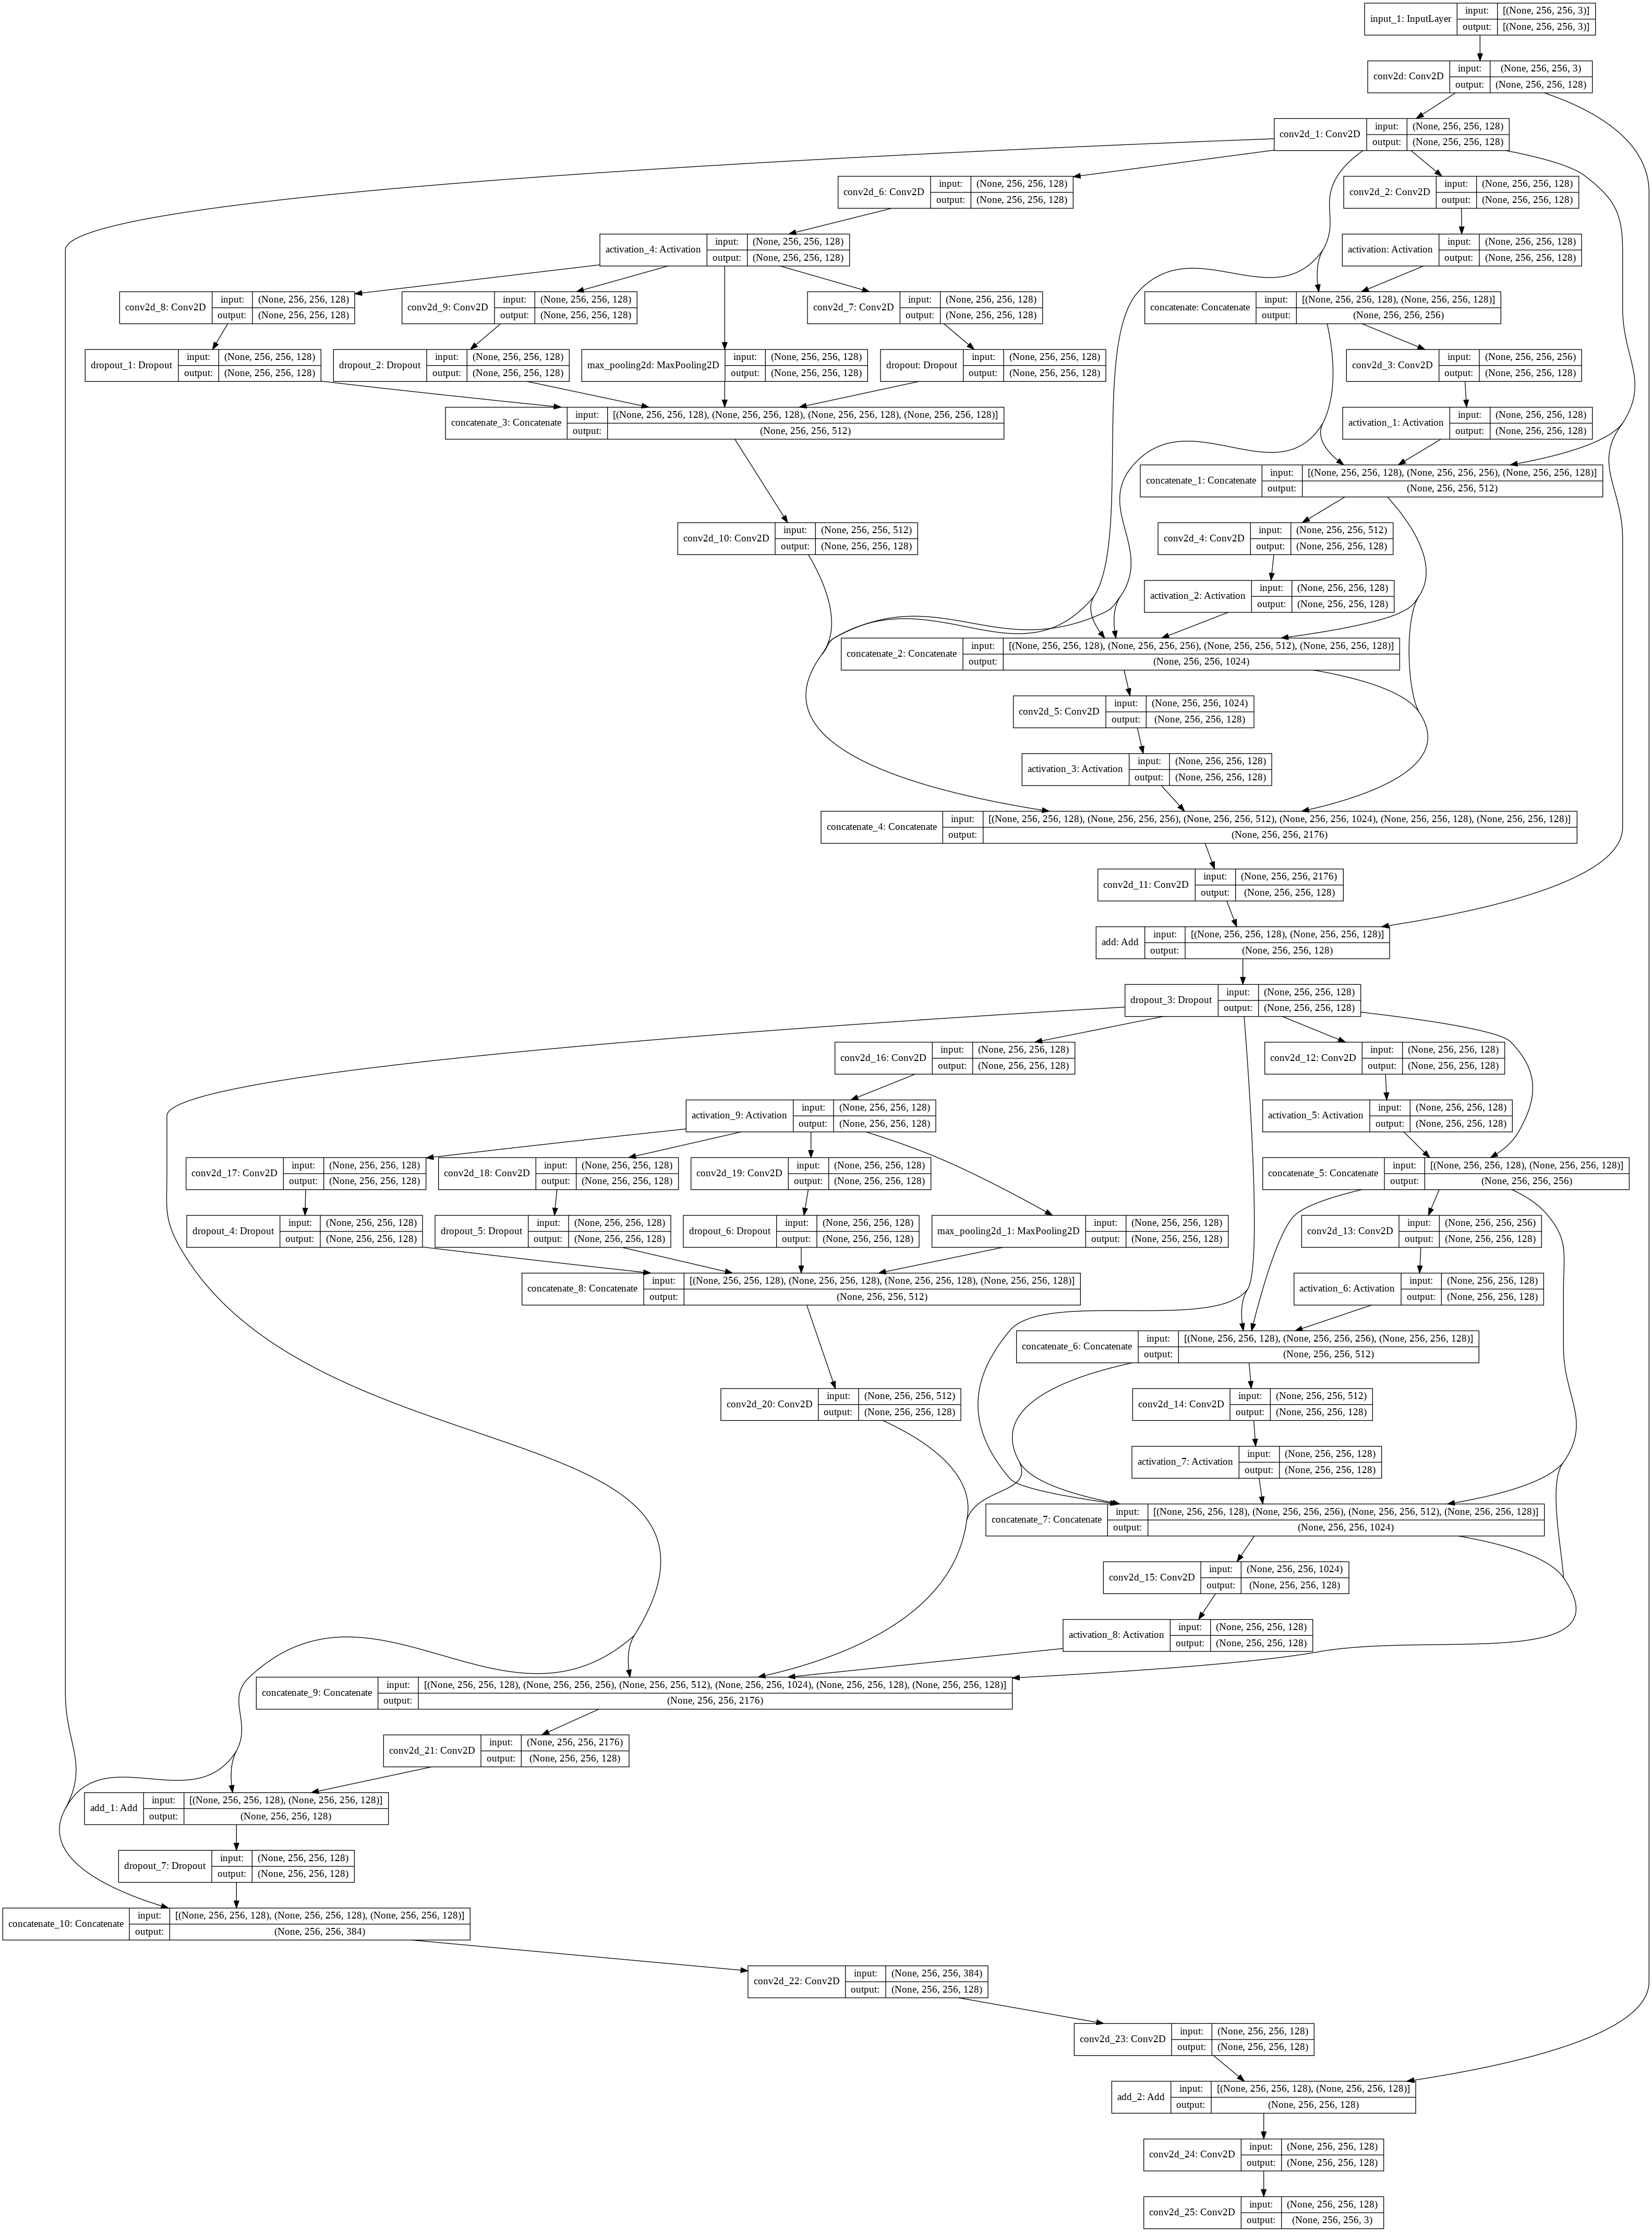

In [9]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
plot_model(model=model, to_file='MRDNetwork.png', show_shapes=True)

### Model architecture ends here

#### Data Augmentaion

In [4]:
#https://www.programcreek.com/python/example/102126/numpy.rot90
def data_aug(img, mode=0):
    '''
    function for data augmentation
    '''
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

#### The below function sorts the list based alpha numeric order

In [5]:
#https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir#:~:text=To%20sort%20the%20result%2C%20use,listdir(path))%20.&text=You%20can%20now%20use%20this,dirlist%20%3D%20sorted_alphanumeric(os.
import re
def sorted_alphanumeric(data):
    '''
    sorts the list based on alpha numeric values
    '''
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#### Train  data generator

In [19]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
def generator(batch_size=2,epoch=450,steps_per_epoch=200):
  '''
  function for train data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_train_clean/'))[2000:3000]
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_train_noisy/'))[2000:3000]
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_train_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_train_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(3):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Test data generator 

In [7]:
def test_generator(batch_size=2,epoch=3,steps_per_epoch=6):
  '''
  function for test data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))[0:200]
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))[0:200]
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_test_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_test_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(6):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Custom loss function 

In [8]:
#https://www.kdnuggets.com/2019/04/advanced-keras-constructing-complex-custom-losses-metrics.html
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

#### Loading last epoch model where last interruption occured. This loaded model remebers the last epoch executed and starts from there

In [9]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
def initial_epochs():
  '''
  This function understands till what epoch model has executed untill last interuption happened
  ''' 
  list_of_epochs=[]
  filepaths=glob.glob('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/*')
  if(not filepaths):
    return 0
  for path in filepaths:
    splitted=path.split('epochs')[1]
    epoch_num=int(splitted.split('.')[0])
    list_of_epochs.append(epoch_num)
  last_epoch=max(list_of_epochs)
  return last_epoch

In [15]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
initial_epoch_ = initial_epochs()

In [16]:
if(initial_epoch_>0):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs%03d.hdf5'%initial_epoch_,compile=False)

#### Compiling

In [17]:
#compiling the model
model.compile(loss=sum_squared_error,
              optimizer = Adam(1.1*1e-5))

##### Set of keras callbacks

In [18]:
#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/model_checkpoint/
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/#:~:text=Early%20stopping%20is%20a%20method,deep%20learning%20neural%20network%20models.
model_save=ModelCheckpoint(
    'drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs{epoch:03d}.hdf5',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq=int(20*150))
#https://keras.io/api/callbacks/learning_rate_scheduler/
'''def scheduler(epoch):
      
      changing initial learning rate for adams optimizer
      
      lri=0.00002
      if epoch < 270:
        lr=lri
        return lr
      elif (epoch <300):
        lr=0.000001
        return lr
      elif (epoch<350):
        lr=0.0000001
        return lr
      elif (epoch<400):
        lr=0.00000001
        return lr
      else:
        lr=0.00000001
        return lr
learning_rate_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)'''
learning_rate_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,
    patience=50,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-11
)

early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=100,
    verbose=1,
    mode="min"
)

callbacklist=[model_save,learning_rate_scheduler,early_stopping]

#### Fitting the model

In [20]:
model.fit(generator(2,150,1000),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=1000,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 541/1000
150/150 [==============================] - 54s 338ms/step - loss: 3247.5870 - val_loss: 3867.9021
Epoch 542/1000
150/150 [==============================] - 46s 306ms/step - loss: 1590.3940 - val_loss: 1816.3032
Epoch 543/1000
150/150 [==============================] - 46s 306ms/step - loss: 1520.5851 - val_loss: 8490.3672
Epoch 544/1000
150/150 [==============================] - 46s 306ms/step - loss: 1571.3053 - val_loss: 7519.1836
Epoch 545/1000
150/150 [==============================] - 46s 306ms/step - loss: 1493.6000 - val_loss: 7449.6797
Epoch 546/1000
150/150 [==============================] - 46s 306ms/step - loss: 1598.3293 - val_loss: 9649.5889
Epoch 547/1000
150/150 [==============================] - 46s 306ms/step - loss: 1321.5888 - val_loss: 5520.6855
Epoch 548/1000
150/150 [==============================] - 46s 307ms/step - loss: 1411.9878 - val_loss: 10271.2461
Epoch 549/1000
150/150 [==============================] - 46s 306ms/step - loss: 1235.0609 - va

### list of things tried with the above architecture.
<ul>
<li>
Used different initial learning rates for adams optimizer when used 0.0001 as learning rate result was changing abruptly with every epoch . Then changed this to 0.00001 stabilized the result 
</li>
<li>
Tried different loss function including custom ssim and custom psnr loss ,but these did not work well may be because of they work on image level . Only square loss worked well.
</li>
<li>
Initially it was overfitting then reduced the architecture complexity,introduced l2 normalization to both bias term and main part. Added dropouts which was helpful to reduce the overfitting little bit. 
</li>
<li>
Tried with different batch sizes . Batch size 3 showed better performance.
</li>
</ul>

#### Validating test data with PSNR score and SSIM score

In [ ]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs087.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
psnr_clean_noisy=[]
ssim_clean_noisy=[]
psnr_clean_predicted=[]
ssim_clean_predicted=[]
for file in tqdm(list_clean):
  clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
  noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
  image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
  predicted=img_to_array(array_to_img(image_predicted[0]))
  psnr_clean_noisy.append(peak_signal_noise_ratio(clean,noisy,data_range=255))
  ssim_clean_noisy.append(structural_similarity(clean,noisy,data_range=255,multichannel=True))
  psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
  ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
length=len(list_clean)
psnr_clean_noisy_avg=sum(psnr_clean_noisy)/length
ssim_clean_noisy_avg=sum(ssim_clean_noisy)/length
psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length

In [ ]:
print('Clean and noisy images average psnr=',psnr_clean_noisy_avg)
print('Clean and noisy images average ssim=',ssim_clean_noisy_avg)
print('Clean and predicted image average psnr=',psnr_clean_predicted_avg)
print('Clean and predicted image average  ssim=',ssim_clean_predicted_avg)

Clean and noisy images average psnr= 24.705783378445734
Clean and noisy images average ssim= 0.7099766528262358
Clean and predicted image average psnr= 27.70139463478091
Clean and predicted image average  ssim= 0.8067689498908663


In [12]:
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
length=len(list_clean)

psnr_clean_noisy=[]
ssim_clean_noisy=[]

for file in os.listdir('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/'):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/'+file,compile=False)
  print('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/'+file)
  psnr_clean_predicted=[]
  ssim_clean_predicted=[]
  for file in tqdm(list_clean):
    clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
    noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
    image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
    predicted=img_to_array(array_to_img(image_predicted[0]))
    psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
    ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
  psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
  print(psnr_clean_predicted_avg)
  ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length
  print(ssim_clean_predicted_avg)

drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs010.hdf5



18.47037416085592
0.4358680073638306
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs020.hdf5



18.131965920624904
0.46692917455942445
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs030.hdf5



17.21279658649448
0.47641314020459774
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs040.hdf5



17.91902258406566
0.4998248592112673
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs050.hdf5



17.588366429799056
0.5062263640243883
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_mrdn/denoiser_epochs060.hdf5


KeyboardInterrupt: ignored

### Displaying images noisy ,clean and predicted

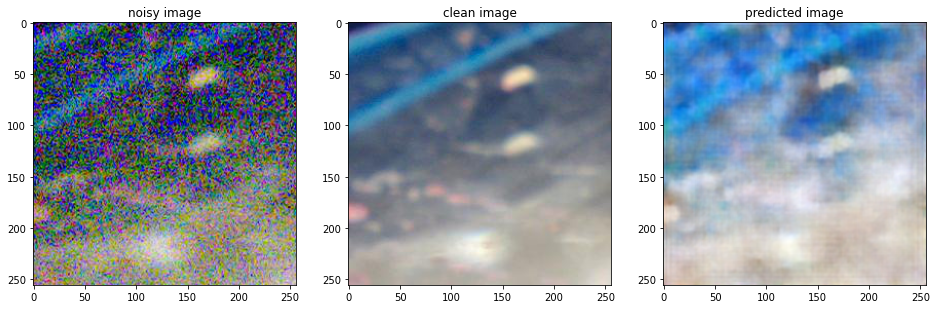

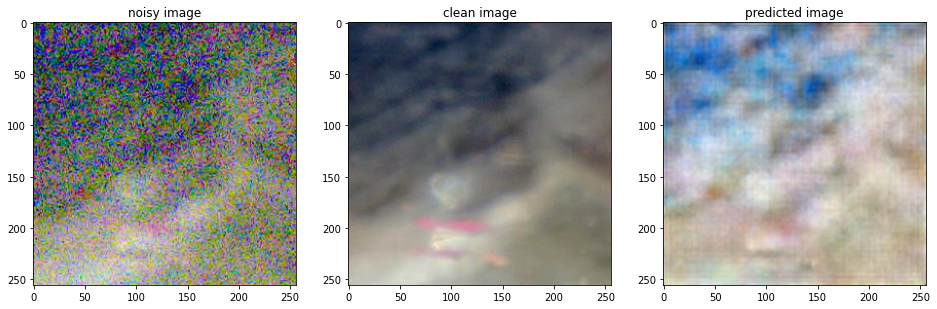

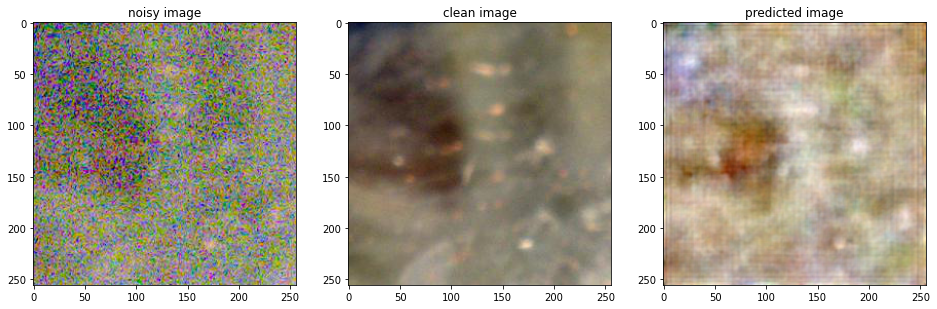

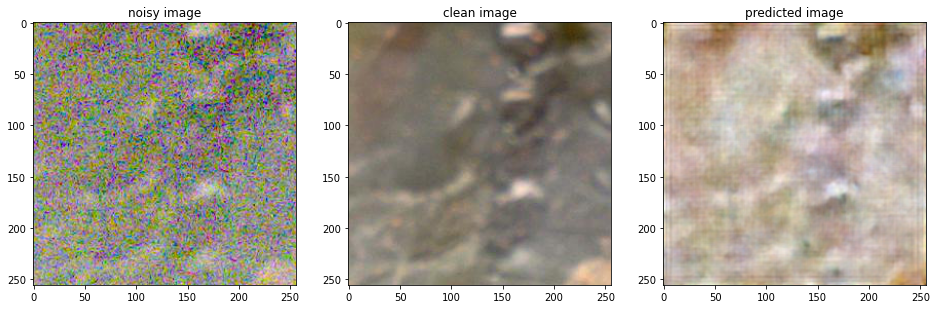

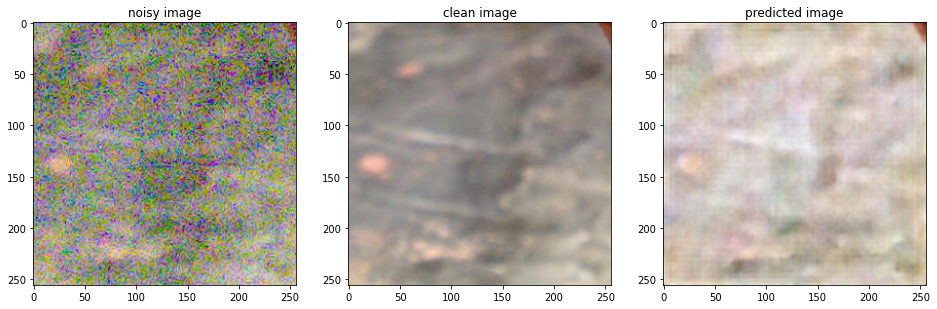

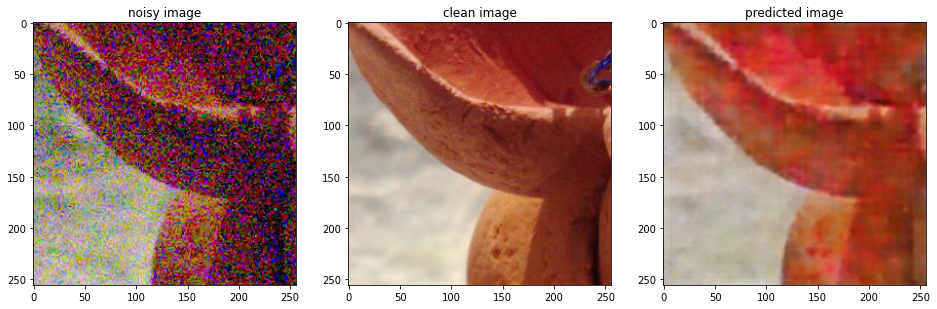

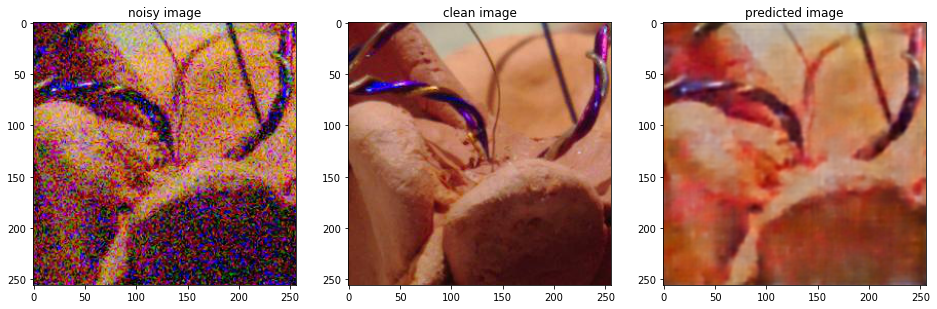

In [22]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs040.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
for file in list_clean[100:107]:
  image_clean=load_img(root_path+'/resized_test_clean/'+file,target_size=(256,256)) 
  image_noise=load_img(root_path+'/resized_test_noisy/'+file,target_size=(256,256))
  image_predicted = model.predict(np.expand_dims(img_to_array(image_noise)/255,axis=0))
  predicted_image = array_to_img(image_predicted[0])

  plt.figure(figsize=(16, 12))
  plt.subplot(131)
  plt.title('noisy image')
  plt.imshow(image_noise)

  plt.subplot(132)
  plt.title('clean image')
  plt.imshow(image_clean)

  plt.subplot(133)
  plt.title('predicted image')
  plt.imshow(predicted_image)

In [ ]:
#https://pypi.org/project/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model", "psnr_clean_noisy", "psnr_clean_predicted",'psnr improvement from model', "ssim_clean_noisy",'ssim_clean_predicted','ssim improvement from model']
x.add_row(["baseline_DnCNN(8 data points taken)", 25.77 ,27.14   ,np.round(27.14 - 25.77,2), 0.7632 , 0.7793  ,np.round(0.7793-0.7632,3)])
x.add_row(["MRDN(10 datapoints taken)", np.round(psnr_clean_noisy_avg,2),np.round(psnr_clean_predicted_avg,2),np.round(psnr_clean_predicted_avg-psnr_clean_noisy_avg,2), np.round(ssim_clean_noisy_avg,4), np.round(ssim_clean_predicted_avg,4),np.round(ssim_clean_predicted_avg-ssim_clean_noisy_avg,4)])

print(x)

+-------------------------------------+------------------+----------------------+-----------------------------+------------------+----------------------+-----------------------------+
|                model                | psnr_clean_noisy | psnr_clean_predicted | psnr improvement from model | ssim_clean_noisy | ssim_clean_predicted | ssim improvement from model |
+-------------------------------------+------------------+----------------------+-----------------------------+------------------+----------------------+-----------------------------+
| baseline_DnCNN(8 data points taken) |      25.77       |        27.14         |             1.37            |      0.7632      |        0.7793        |            0.016            |
|      MRDN(10 datapoints taken)      |      24.71       |        27.58         |             2.87            |       0.71       |        0.8005        |            0.0906           |
+-------------------------------------+------------------+----------------------

### Conclusion and final points: MRDN model is showing better improvements interms of ssim and psnr compared to baseline_DnCNN like model. In the actual competion Samsung team trains MRDN model for 7 days and on large number of data. As I have limited resources trained it on 633 different data points and applied  image augmentation on it. Trained it for 3 to 4 hours. I feel that there is goood improvements interms of SSIM value compared to PSNR.

In [ ]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit